<a href="https://colab.research.google.com/github/fressbish/Koptev-Dmitry/blob/main/task3_Koptev_Dmitry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Дмитрий Коптев
#### Задание 3
https://github.com/rustam-azimov/graph-course-itmo/blob/main/tasks/task3.md

In [1]:
# pip install python-graphblas[default]

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import networkx as nx

import graphblas as gb
from graphblas.io import mmread
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring

# Bellman Ford

Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из заданной вершины (Bellman–Ford).
- Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и номер стартовой вершины
- Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [3]:
def BellmanFord(A, vertex):
    m = A.nrows
    v = Vector(A.dtype, m)
    v[vertex] << 0

    w = v.dup()
    for i in range(m - 1):
        w_ = w.dup()
        w(binary.min) << w.vxm(A, semiring.min_plus)
        if w.isequal(w_):
            break

    # проверка отрицательных весов
    w_ = w.dup()
    w(binary.min) << w.vxm(A, semiring.min_plus)
    if not w.isequal(w_):
        return "Отрицательный вес"

    res = []
    for i in range(m):
        # если вершина недостижима
        if w[i].value is None:
            res.append(float('inf'))
        # если вершина достижима – расстояние от стартовой вершины до остальных
        else:
            res.append(w[i].value)
    return res

# Bellman Ford с несколькими стартовыми вершинами

Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из нескольких заданных вершин, модифицировав предыдущий алгоритм.
- Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин. <br><br>
- Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [4]:
def BellmanFordMultiple(A, arr):
    n = A.ncols
    m = arr.size
    # матрица с начальными вершинами
    v = Matrix(dtypes.INT32, m, n)
    for i in range(m):
      v[i, arr[i]] << 0

    w = v.dup()
    for i in range(n - 1):
      w_ = w.dup()
      for i in range(m):
        w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
      if w.isequal(w_):
        break

    # проверка отрицательных весов
    w_ = w.dup()
    for i in range(m):
      w[i,:](binary.min) << w[i,:].vxm(A, semiring.min_plus)
    if not w.isequal(w_):
      return "Отрицательный вес"

    res = {}
    for i in range(m):
      values = []
      for j in range(n):
        # если вершина недостижима
        if w[i, j].value is None:
          values.append(float('inf'))
          # если вершина достижима – расстояние от стартовой вершины до остальных
        else:
          values.append(w[i, j].value)
      res[arr[i]] = (values)
    return res

# Floyd–Warshall и вычисление транзитивного замыкания

Используя python-graphblas реализовать две функции поиска кратчайших путей в ориентированном графе для всех пар вершин (Floyd–Warshall и вычисление транзитивного замыкания).
- Функции принимают представление графа, удобное для неё (загрузка, конвертация реализованы отдельно).
- Функции возвращают массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [5]:
def FloydWarshall(M):

    distance = M.dup()
    n = M.nrows
    distance_ = M.dup()

    for k in range(n):
      dist_col = Matrix(dtypes.INT32, n, n)
      dist_row = Matrix(dtypes.INT32, n, n)
      dist_col[:, k] = distance[:, k].dup()
      dist_row[k, :] = distance[k, :].dup()
      distance_ << dist_col.mxm(dist_row, semiring.min_plus)
      distance << distance.ewise_add(distance_, op="min")

    # проверка отрицательных весов
    distance1 = distance.dup()
    distance_1 = distance_.dup()
    dist_col1 = Matrix(dtypes.INT32, n, n)
    dist_row1 = Matrix(dtypes.INT32, n, n)
    dist_col1[:, k] = distance1[:, k].dup()
    dist_row1[k, :] = distance1[k, :].dup()
    distance_1 << dist_col1.mxm(dist_row1, semiring.min_plus)
    distance1 << distance1.ewise_add(distance_1, op="min")
    if not distance1.isequal(distance):
        return "Отрицательный вес"

    res = {}
    for i in range(n):
      vals = []
      for j in range(n):
        if i == j:
          vals.append(0)
        elif distance[i, j].value is None:
          vals.append(float('inf'))
        else:
          vals.append(distance[i, j].value)
      res[i] = np.array(vals)
    return res


In [6]:
def TransitiveClosure(M):
    rows = M.nrows
    I = Matrix(dtypes.INT32, rows, rows)
    for i in range(rows):
      I[i, i] = 1
    D = I.dup()

    for i in range(rows):
      D1 = D.dup()
      D = D.mxm(m, semiring.min_plus).ewise_add(I, op="min")
      if D1.isequal(D):
        break

    D2 = D.dup()
    D2 = D2.mxm(m, semiring.min_plus).ewise_add(I, op="min")
    if not D2.isequal(D):
      return "Отрицательный вес"

    res = {}
    for i in range(rows):
      vals = []
      for j in range(rows):
        if D[i, j].value is None:
          vals.append(float('inf'))
        elif i == j:
          vals.append(0)
        else:
          vals.append(D[i, j].value - 1)
      res[i] = np.array(vals)
    return res

# Тесты

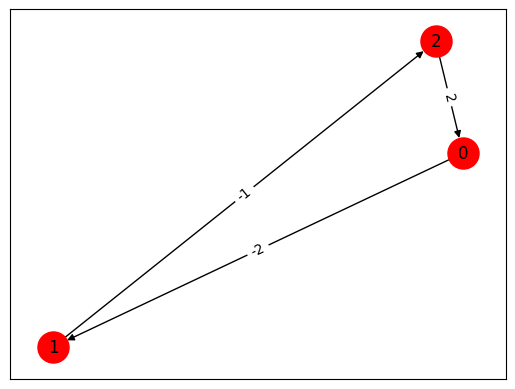

('Отрицательный вес',
 'Отрицательный вес',
 'Отрицательный вес',
 'Отрицательный вес')

In [7]:
# Проверка на отрицательные веса

m = gb.Matrix.from_coo(
    [1, 2, 0],
    [2, 0, 1],
    [-1,2,-2],
    nrows=3,
    ncols=3
)
gb.viz.draw(m)

BellmanFord(m, 2), BellmanFordMultiple(m, np.array([0,2])), FloydWarshall(m), TransitiveClosure(m),

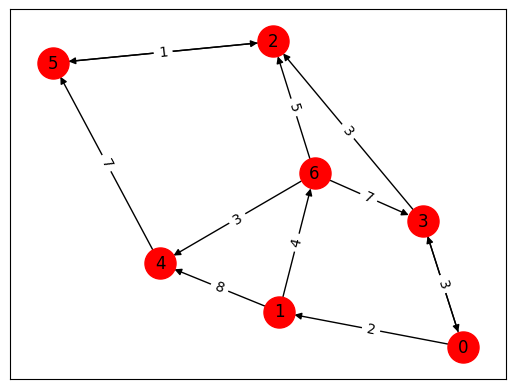

In [8]:
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]
rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)
gb.viz.draw(m)

### Bellman-Ford

Из вершины 1:
- до 0 вершины кратчайший путь 1->6->3->0 = 14
- до 2 вершины кратчайший путь 1->6->2 = 9
- до 3 вершины кратчайший путь 1->6->3 = 11
- до 4 вершины кратчайший путь 1->6->4 = 7
- до 5 вершины кратчайший путь 1->6->2->5 = 10
- до 6 вершины кратчайший путь прямой = 4

In [9]:
print('BellmanFord:', BellmanFord(m, 1), sep='\n\n')

BellmanFord:

[14, 0, 9, 11, 7, 10, 4]


Из вершины 2:
- достижима только вершина 5, путь = 1

In [10]:
print('BellmanFord:', BellmanFord(m, 2), sep='\n\n')

BellmanFord:

[inf, inf, 0, inf, inf, 1, inf]


Из вершины 3:
- до 0 и 2 вершин кратчайший путь прямой = 3 для обеих вершин
- до 1 вершины кратчайший путь через 3->0->1 = 5
- до 6 вершины кратчайший путь 3->0->1->6 = 9
- до 4 вершины кратчайший путь 3->0->1->6->4 = 12
- до 5 вершины кратчайший путь 3->2->5 = 4

In [11]:
print('BellmanFord:', BellmanFord(m, 3), sep='\n\n')

BellmanFord:

[3, 5, 3, 0, 12, 4, 9]


### Сравним работу двух функций:

In [12]:
print('Bellman-Ford с одной вершиной:\n',
      BellmanFord(m, 0), '\n',
      BellmanFord(m, 1), '\n',
      BellmanFord(m, 2), '\n',
      BellmanFord(m, 3), '\n',
      BellmanFord(m, 4), '\n',
      BellmanFord(m, 5), '\n',
      BellmanFord(m, 6))

Bellman-Ford с одной вершиной:
 [0, 2, 6, 3, 9, 7, 6] 
 [14, 0, 9, 11, 7, 10, 4] 
 [inf, inf, 0, inf, inf, 1, inf] 
 [3, 5, 3, 0, 12, 4, 9] 
 [inf, inf, 8, inf, 0, 7, inf] 
 [inf, inf, 1, inf, inf, 0, inf] 
 [10, 12, 5, 7, 3, 6, 0]


In [13]:
print('Bellman-Ford с несколькими вершинами:\n')
for row in BellmanFordMultiple(m, np.array([0,1,2,3,4,5,6])).items():
    print(row)

Bellman-Ford с несколькими вершинами:

(0, [0, 2, 6, 3, 9, 7, 6])
(1, [14, 0, 9, 11, 7, 10, 4])
(2, [inf, inf, 0, inf, inf, 1, inf])
(3, [3, 5, 3, 0, 12, 4, 9])
(4, [inf, inf, 8, inf, 0, 7, inf])
(5, [inf, inf, 1, inf, inf, 0, inf])
(6, [10, 12, 5, 7, 3, 6, 0])


In [14]:
print('FloydWarshall:\n')
for row in FloydWarshall(m).items():
    print(row)

FloydWarshall:

(0, array([0, 2, 6, 3, 9, 7, 6]))
(1, array([14,  0,  9, 11,  7, 10,  4]))
(2, array([inf, inf,  0., inf, inf,  1., inf]))
(3, array([ 3,  5,  3,  0, 12,  4,  9]))
(4, array([inf, inf,  8., inf,  0.,  7., inf]))
(5, array([inf, inf,  1., inf, inf,  0., inf]))
(6, array([10, 12,  5,  7,  3,  6,  0]))


In [15]:
print('TransitiveClosure:\n')
for row in TransitiveClosure(m).items():
    print(row)

TransitiveClosure:

(0, array([0, 2, 6, 3, 9, 7, 6]))
(1, array([14,  0,  9, 11,  7, 10,  4]))
(2, array([inf, inf,  0., inf, inf,  1., inf]))
(3, array([ 3,  5,  3,  0, 12,  4,  9]))
(4, array([inf, inf,  8., inf,  0.,  7., inf]))
(5, array([inf, inf,  1., inf, inf,  0., inf]))
(6, array([10, 12,  5,  7,  3,  6,  0]))


In [16]:
assert (BellmanFordMultiple(m, np.array([1,2,3]))[1] == BellmanFord(m, 1))
assert (BellmanFordMultiple(m, np.array([1,2,3]))[2] == BellmanFord(m, 2))
assert (FloydWarshall(m)[3] == BellmanFord(m, 3)).all()
assert (FloydWarshall(m)[4] == BellmanFord(m, 4)).all()
assert (FloydWarshall(m)[5] == TransitiveClosure(m)[5]).all()
assert (FloydWarshall(m)[6] == TransitiveClosure(m)[6]).all()